In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On s'intéresse à approximer la solution de l'équation de transport suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2}+f(x,t) \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}
<span style="color:red;">Premier cas:</span>

La solution exacte:
$$
u(x,t)=\alpha e^{-2\beta t} sin(2\pi x)
$$
$$ \Longrightarrow{} u_t = -2\alpha \beta e^{-2\beta t}sin(2\pi x)=-2\beta u$$
et 
$$ u_x = 2 \pi \alpha e^{-2 \beta t} cos(2\pi x)$$
et 
$$ u_{xx} = -(2 \pi)^2 \alpha e^{-2 \beta t} sin(2\pi x)=-(2\pi )^2 u$$
Par suite:
\begin{align}
f(x,t) & = u_t+au_x-\epsilon u_{xx} \\
& = (\epsilon (2 \pi)^2 - 2\beta ) u+ 2\pi \alpha a e^{-2\beta t} cos(2 \pi x) 
\end{align}

<span style="color:red;">Deuxieme cas:</span>
$$ 
u(t, x) = 
\begin{cases} 
tx & \text{if } 0 \leq x \leq 1 \\
t & \text{if } 1 \leq x \leq 3 \\
t(4 - x) & \text{if } 3 \leq x \leq 4
\end{cases}
$$
Ce qui implique:
$$ 
f(t, x) = 
\begin{cases} 
x+at & \text{if } 0 \leq x \leq 1 \\
1 & \text{if } 1 \leq x \leq 3 \\
(4-x) -at & \text{if } 3 \leq x \leq 4
\end{cases}
$$

In [23]:
#La Solution Exacte:
@njit(cache=True)
def u_exacte1(x,t, ALPHA, beta):
    return ALPHA * np.exp(-2 * beta * t) * np.sin(2 * np.pi * x)


@njit(cache=True)
def u_exacte2(x,t, ALPHA, beta):
    if x>= 0 and x<=1:
        return t*x
    elif x>1 and x<=3:
        return t
    elif x> 3:
        return t*(4-x)
    
    

#Le terme source
@njit(cache=True)
def f1(x, t, ALPHA, beta , epsilon , a):
    A1 = epsilon * 4 * np.pi**2 - 2 * beta 
    A2 = 2*np.pi * ALPHA * a * np.exp(-2 * beta *t) * np.cos(2* np.pi *x)
    u  = ALPHA * np.exp(-2 * beta * t) * np.sin(2 * np.pi * x)
    return A1 * u + A2
@njit(cache=True)
def f2(x, t, ALPHA, beta , epsilon, a):
    
    if x>= 0 and x<=1:
        return x+a*t
    elif x>1 and x<=3:
        return 1
    elif x> 3:
        return (4-x) -a*t


# Le flux Exacte:
@njit(cache=True)
def F(u,a):
    return a*u

# Les Flux des schemas:
@njit(cache=True)
def Rusanov(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a))-a*(ud-ug)

@njit(cache=True)
def Rusanov2(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-a*(ud-ug))

@njit(cache=True)
def Roe(ug,ud,a,dx,dt):
    if a >= 0:
        return F(ug,a)
    else:
        return F(ud,a)
    
@njit(cache=True)
def LF(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dx/(dt))*(ud-ug))
       
@njit(cache=True)
def LFM(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-0.5*(dx/(dt))*(ud-ug))
       
    
@njit
def LW(ug,ud, a, dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dt/dx)*(a**2)*(ud-ug))


@njit(cache=True)
def VFD(ug,ud, a, dx,dt):
    return F(ug,a)





#@njit(cache=True)
def depature_fvc_flux(dt,alpha,x,a):
    aux=1
    eps=1e-9
    x0=0.5*(x[0]+x[1])   
    x1=x0
    xmp=x0
    while(aux>eps):
        x1=xmp-dt*alpha*a
        aux=np.abs(x0-x1)
        x0=x1
    if x0>x[1]:
        x0=x[1]
    if x0<x[0]:
        x0=x[0]    
    return x0 

 
#@njit(cache=True)
def fvc_flux(u,x,dt,alpha,a):
    
    Alpha = alpha
    x_car = depature_fvc_flux(dt, Alpha,x,  a)

    up   = np.interp(x_car, x, u)
    

    return a * up

#@njit(cache=True)
def VFC(U0, T, epsilon, N,  alpha, dx, CFL, X, ALPHA, beta, Case):
    if Case == 1:
        f = f1
    elif Case == 2:
        f=f2
        
    if epsilon != 0 and a!=0:
        Dt1  = CFL * (dx/(np.abs(a)*np.sqrt(2*alpha)))
        Dt2  = CFL * 0.5 * dx**2 / np.abs(epsilon)
        dt  = min(Dt1,Dt2)
    else:
        if epsilon == 0:
            dt  = CFL * (dx/(np.abs(a)*np.sqrt(2*alpha)))
        elif a == 0:
            dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    Un    = U0.copy()
    Unp1  = np.zeros(N)
    
    temps = 0
    

    
    while temps < T:
        
        
        temps += min(dt,T-dt)
        
        for i in range(1,N-1):
            X1   = [X[i-1],X[i]]
            u1   = [Un[i-1],Un[i]]
            
            X2   = [X[i],X[i+1]]
            u2   = [Un[i],Un[i+1]]
            
            Fg  = fvc_flux(u1,X1,dt,alpha,a)
            Fd  = fvc_flux(u2,X2,dt,alpha,a)
            
            
            Unp1[i]=Un[i]-dt/dx*(Fd-Fg) + epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])+  dt  * f(X[i], temps, ALPHA, beta , epsilon , a)   
            
        Unp1[0]   = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]
        Un = Unp1.copy()
    return Un




#@njit(cache=True)
def Solver(U0, T, l, L, a, N, CFL, dx, scheme, X, ALPHA ,beta , Case  ):
    
    if Case == 1:
        f = f1
    elif Case == 2:
        f = f2

    if scheme == 0:
        flux = Roe 
        if epsilon != 0 and a!=0:
            dt  = CFL /(np.abs(a)/dx + 2 * np.abs(epsilon)/(dx**2))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 1:
        flux = Rusanov
        if epsilon != 0 and a!=0:
            dt  = CFL *(dx / np.abs(a))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 2:
        flux = Rusanov2
        if epsilon != 0 and a!=0:
            dt  = CFL *(dx / np.abs(a))
        else:
            if epsilon == 0:
                dt  = CFL * dx / np.abs(a)
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 3:
        flux = LF
        if epsilon != 0 and a!=0:
            dt  = CFL /(np.abs(0.5*a/dx -epsilon/(dx**2)))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 4:
        flux = LFM
        if epsilon != 0 and a!=0:
            dt  = CFL /(np.abs(0.5*a/dx -epsilon/(dx**2)))
        else:
            if epsilon == 0:
                dt  =  CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
        
    elif scheme == 5:
        flux = LW
        dt1 =  CFL*dx/np.abs(a)
        dt2 =  CFL * 0.5 * dx**2 / np.abs(epsilon)
        dt  =  min(dt1,dt2)
    elif scheme == 6:
        flux = VFD
        if epsilon != 0 and a!=0:
            dt  = CFL /(np.abs(a)/dx + 2 * np.abs(epsilon)/(dx**2))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    while temps < T:
        dt = min(dt, T - temps)
        temps += dt

        for i in range(1, N - 1):
            Fd = flux ( Un[i], Un[i + 1], a, dx, dt )
            Fg = flux ( Un[i - 1], Un[i], a, dx, dt )
    
            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1]) +  dt  * f(X[i], temps, ALPHA, beta , epsilon , a)                                       

        Unp1[0] = 0#Unp1[1]
        Unp1[N - 1] = 0#Unp1[N - 2]

        Un[:] = Unp1[:]

    return Un

  
######################################################################################
Case    =  2         # 1 or 2
T       =  1
l       =  0

if Case == 1:
    L = 1
    u_exacte = u_exacte1
else :
    L = 4
    u_exacte = u_exacte2
    
a       =  2
epsilon =  1e-2
N       =  101
CFL     =  1/2
alpha   =  0.7

beta    =  1/2
ALPHA   =  2

X       =  np.linspace(l,L,N)
dx      =  (L-l)/(N-1)

U0      =  np.array([u_exacte(x,0, ALPHA, beta) for x in X])




fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):0, ("LFM",4):0, ("LW",5):1, ("VFD",6):1}

results={}
for i,j in fluxes.items():  
    if j:
        results[i[0]]  =  Solver  (U0, T, l, L, a, N, CFL, dx, i[1],X, ALPHA ,beta, Case)   
    


U_VFC = VFC(U0, T, epsilon, N,  alpha, dx, CFL,X, ALPHA , beta, Case)
results['VFC'] = U_VFC

UExact = np.array([u_exacte(x,T, ALPHA, beta) for x in X])


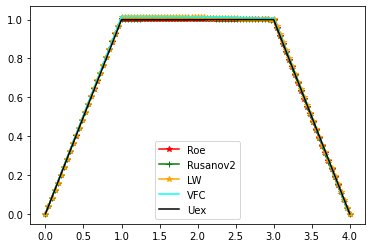

In [24]:
PLOT = {"Roe":1, "Rusanov":0, "Rusanov2":1, "LF":1, "LFM":0, "LW":1, "VFD":0 , "VFC":0}

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']
symbols = ['-*', '-', '-+', '-*', '--', '-', '--', '--']

for i, (flux, Un) in enumerate(results.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, list(symbols)[i], label=flux, color=colors[i])
    
plt.plot(X, UExact, '-k',  label='Uex')

#plt.xlim([0.5, 1.2])  
#plt.ylim([0.8, 1.2 ])

plt.legend()
plt.pause(0.1)


In [25]:
Errors = {}
for i, (flux, Un) in enumerate(results.items()):
    Errors[flux]    =  np.linalg.norm(Un-UExact,ord = 2)
Errors

{'Roe': 0.0511621518128429,
 'Rusanov': 66746.01013618511,
 'Rusanov2': 0.06364321605566159,
 'LW': 0.08501775421779176,
 'VFD': 0.0511621518128429,
 'VFC': 0.11058045880744664}